## National Vegetation Classification System (NVCS) Protection Summary by Management Category

This notebook is intended to provide code used in a summarization for NVCS classes for GAP Protected Areas Database (PAD) status levels 1, 2, and 3 across PAD mangement categories.
    
It utilizes an SQL server database assembled by intersecting numerous raster data layers created by the Gap Analysis Program including the PAD-US, species habitat maps, boundary layers such as states, counties, LCCs, ecoregions, etc. That database (the GAP Analytic database) at the time of this workflow development was only available on a local server. Hence, all code references a local instance of this database. This code is only replicable given access to a local instance of the database.

#### Accessing the local SQL server instance of the GAP Analytic database

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import pandas.io.sql as psql
import seaborn as sns
import matplotlib.pyplot as plt


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#            ++++ Directory Locations ++++
workDir = 'C:/Data/USGS Analyses/NVC-Analyses/Scripts/'


#############################################################################################
################################### LOCAL FUNCTIONS #########################################
#############################################################################################


## --------------Cursor and Database Connections--------------------

def ConnectToDB(connectionStr):
    '''
    (str) -> cursor, connection

    Provides a cursor within and a connection to the database

    Argument:
    connectionStr -- The SQL Server compatible connection string
        for connecting to a database
    '''
    try:
        con = pyodbc.connect(connectionStr)
    except:
        connectionStr = connectionStr.replace('11.0', '10.0')
        con = pyodbc.connect(connectionStr)

    return con.cursor(), con

## ----------------Database Connection----------------------

def ConnectAnalyticDB():
    '''
    Returns a cursor and connection within the GAP analytic database.
    '''
    # Database connection parameters
    dbConStr = """DRIVER=SQL Server Native Client 11.0;
                    SERVER=CHUCK\SQL2014;
                    UID=;
                    PWD=;
                    TRUSTED_CONNECTION=Yes;
                    DATABASE=GAP_AnalyticDB;"""

    return ConnectToDB(dbConStr)


#############################################################################################
#############################################################################################
#############################################################################################


In [2]:
## Connect to the Analytic Database
print("+"*45)
print("Connecting to Database ....")
cur, conn = ConnectAnalyticDB()

+++++++++++++++++++++++++++++++++++++++++++++
Connecting to Database ....


#### Generating an SQL string to pass to a pandas dataframe

In [3]:
## The SQL to pull out NVC Classes, PAD management and status data from the analytic db
sql = """


SELECT
	padus1_4.gap_sts as PADStatus,
	padus1_4.d_mang_nam as ManageName,
	padus1_4.d_mang_typ as ManageType,
	gap_landfire.nvc_class as NVCClass,
	--gap_landfire.nvc_group as NVCGroup,
	sum(lu_boundary_gap_landfire.count) as nCells
FROM	lu_boundary INNER JOIN lu_boundary_gap_landfire INNER JOIN gap_landfire
	ON	lu_boundary_gap_landfire.gap_landfire = gap_landfire.value
	ON	lu_boundary.value = lu_boundary_gap_landfire.boundary INNER JOIN padus1_4
	ON	lu_boundary.padus1_4 = padus1_4.objectid
GROUP BY
  padus1_4.d_mang_nam,
  padus1_4.d_mang_typ,
  padus1_4.gap_sts, 
  gap_landfire.nvc_class
  --gap_landfire.nvc_group

"""

#### Passing the SQL and getting a pandas dataframe

In [4]:
# Make a dataframe from the results of the SQL query
print("Creating Initial Dataframe ....")
df = psql.read_sql(sql, conn)

Creating Initial Dataframe ....


In [7]:
df

,PADStatus,NVCClass,ManageName,nCellSum
0,1,Agricultural & Developed Vegetation,Department of Defense,43
1,1,Agricultural & Developed Vegetation,Forest Service,46936
2,1,Agricultural & Developed Vegetation,Joint,5154
3,1,Agricultural & Developed Vegetation,Private,924045
4,1,Agricultural & Developed Vegetation,State Park and Recreation,76594
5,1,Agricultural & Developed Vegetation,Tennessee Valley Authority,488
6,1,Desert & Semi-Desert,Non-Governmental Organization,12429
7,1,Developed & Other Human Use,Department of Defense,121
8,1,Developed & Other Human Use,Forest Service,153184
9,1,Developed & Other Human Use,Joint,4340


#### Pull out only the natural/non-anthropogenic NVC classes

In [5]:
# Pull out only the natural/non-anthropogenic NVC classes
print("Removing Anthropogenic Classes ....")
df2 = df[(df['NVCClass'] == 'Forest & Woodland') | 
         (df['NVCClass'] == 'Shrub & Herb Vegetation') | 
         (df['NVCClass'] == 'Desert & Semi-Desert') | 
         (df['NVCClass'] == 'Polar & High Montane Scrub, Grassland & Barrens') | 
         (df['NVCClass'] == 'Open Rock Vegetation')]

Removing Anthropogenic Classes ....


#### Add a new column for area in square kilometers -- (ignore the Python warnings)

In [6]:
# Add a new column for area in square kilometers
print("Calculating Area in km2 ....")
df2['km2'] = df2['nCells']*0.0009

Calculating Area in km2 ....


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Add a new column ManageCat that standarizes management types

In [7]:
# Add a new column ManageCat that standarizes management types
categories = {'Bureau of Land Management':'Bureau of Land Management',
'Forest Service':'Forest Service',
'National Park Service':'National Park Service',
'U.S. Fish & Wildlife Service':'U.S. Fish & Wildlife Service',
'American Indian Lands':'Other',
'City Land':'Other',
'County Land':'Other',
'Joint':'Other',
'Non-Governmental Organization':'Other',
'Other':'Other',
'Other or Unknown Local Government':'Other',
'Private':'Other',
'Regional Agency Land':'Other',
'Regional Water Districts':'Other',
'Unknown':'Other',
'Agricultural Research Service':'Other Federal',
'Army Corps of Engineers':'Other Federal',
'Bureau of Indian Affairs':'Other Federal',
'Bureau of Reclamation':'Other Federal',
'Department of Defense':'Other Federal',
'Department of Energy':'Other Federal',
'National Oceanic and Atmospheric Administration':'Other Federal',
'Other or Unknown Federal Land':'Other Federal',
'Tennessee Valley Authority':'Other Federal',
'Natural Resources Conservation Service':'Other Federal',
'Other or Unknown State Land':'State',
'State Department of Conservation':'State',
'State Department of Land':'State',
'State Department of Natural Resources':'State',
'State Fish and Wildlife':'State',
'State Land Board':'State',
'State Park and Recreation':'State'}
print("Adding a Management Category Column ....")
df2['ManageCat'] = df2['ManageName'].map(categories)

Adding a Management Category Column ....


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Remove the PAD status 4 records and shorten the "Polar" class text

In [8]:
# Make a new dataframe excluding PAD status 4 records
df3 = df2[(df2['PADStatus'] != '4')]
# Shorten the class text 'Polar & High Montane Scrub, Grassland & Barrens'
#  to 'Polar & High Montane' for better plotting
df3['NVCClass'] = np.where(df3['NVCClass']==
   'Polar & High Montane Scrub, Grassland & Barrens',
   'Polar & High Montane', df3['NVCClass'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### Import the bokeh package for plotting and then start manipulating and organizing the data to prepare it as the data source for a bar chart figure

In [9]:
'''

    Plot stacked bar plots

'''
print("===== Begin Plotting =====")
# Using bokeh to plot with hierarchical labeling
from bokeh.core.properties import value
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.models import NumeralTickFormatter

# Bokeh generates an HTML file for the figure
output_file(workDir + "ManagementSummary.html")

===== Begin Plotting =====


In [10]:
# -----------------------------------------------------------------------------
# Manipulate the dataframe to organize data to use as the plotting source

# Add a Status column based on PAD Status to summarize area protection
print("  adding protection status column ...")
df3['Status'] = np.where(df3['PADStatus']=='3', 'Multiple Use', 'Protected')

# Drop PADStatus, ManageName, and nCellSum
df3 = df3.drop(['PADStatus','ManageName','nCells'], axis=1)
# There is no entry of 'Protected' (i.e. status 1 and/or 2) for Polar & High Montane
#   - 'Other Federal' in the data making the records for status pairs uneven.
#  Add a row that is 0 for these criteria
dfa = pd.DataFrame([['Polar & High Montane',0.0,'Other Federal','Protected']],
                   columns=['NVCClass','km2','ManageCat','Status'])
df3 = df3.append(dfa, ignore_index=True)

# Summarize protection area by category, class, and status
print("  summarizing by protection area by category, class and status ...")
dfSumKm = df3.groupby(by=['ManageCat','NVCClass','Status'])['km2'].sum().reset_index()
# Make a column of tupled category and class to index off
dfSumKm['CatCls'] = list(zip(dfSumKm['ManageCat'], dfSumKm['NVCClass']))
# Drop ManageCat and NVCClass columns
dfSumKm = dfSumKm.drop(['ManageCat','NVCClass'], axis=1)

# Pivot on Status and make the tupled category and class column the index
print("  pivoting on status column ...")
df4 = dfSumKm.pivot(index='CatCls', columns='Status', values='km2')
# Reorder columns
df4 = df4[['Protected', 'Multiple Use']]

# Reorder the rows using a preset order dictionary
print("  reordering rows ...")
sort = {('Bureau of Land Management', 'Forest & Woodland'):1,
('Bureau of Land Management', 'Shrub & Herb Vegetation'):2,
('Bureau of Land Management', 'Desert & Semi-Desert'):3,
('Bureau of Land Management', 'Polar & High Montane'):4,
('Bureau of Land Management', 'Open Rock Vegetation'):5,
('Forest Service', 'Forest & Woodland'):6,
('Forest Service', 'Shrub & Herb Vegetation'):7,
('Forest Service', 'Desert & Semi-Desert'):8,
('Forest Service', 'Polar & High Montane'):9,
('Forest Service', 'Open Rock Vegetation'):10,
('National Park Service', 'Forest & Woodland'):11,
('National Park Service', 'Shrub & Herb Vegetation'):12,
('National Park Service', 'Desert & Semi-Desert'):13,
('National Park Service', 'Polar & High Montane'):14,
('National Park Service', 'Open Rock Vegetation'):15,
('U.S. Fish & Wildlife Service', 'Forest & Woodland'):16,
('U.S. Fish & Wildlife Service', 'Shrub & Herb Vegetation'):17,
('U.S. Fish & Wildlife Service', 'Desert & Semi-Desert'):18,
('U.S. Fish & Wildlife Service', 'Polar & High Montane'):19,
('U.S. Fish & Wildlife Service', 'Open Rock Vegetation'):20,
('Other Federal', 'Forest & Woodland'):21,
('Other Federal', 'Shrub & Herb Vegetation'):22,
('Other Federal', 'Desert & Semi-Desert'):23,
('Other Federal', 'Polar & High Montane'):24,
('Other Federal', 'Open Rock Vegetation'):25,
('State', 'Forest & Woodland'):26,
('State', 'Shrub & Herb Vegetation'):27,
('State', 'Desert & Semi-Desert'):28,
('State', 'Polar & High Montane'):29,
('State', 'Open Rock Vegetation'):30,
('Other', 'Forest & Woodland'):31,
('Other', 'Shrub & Herb Vegetation'):32,
('Other', 'Desert & Semi-Desert'):33,
('Other', 'Polar & High Montane'):34,
('Other', 'Open Rock Vegetation'):35}

# Make a new dataframe by resetting the df4 index
df5 = df4.reset_index()
# Add the sortid column for sorting then sort
df5['sortid'] = df5['CatCls'].map(sort)
df5sort = df5.sort_values(by='sortid')
# Drop the sortid column then change the index back to CatCls
dfSource = df5sort.drop(['sortid'],axis=1)
dfSource = dfSource.set_index(keys=['CatCls'])

  adding protection status column ...
  summarizing by protection area by category, class and status ...
  pivoting on status column ...
  reordering rows ...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


#### Configure the data and create an HTML file of the stacked bar chart

Note that the HTML file of the bar chart figure is interactive. There is a toolbar on the right side of the chart area.

In [11]:
# +++++++++++++++++++++++++++++++++++++++ Plotting +++++++++++++++++++++++++++++++++++++++++++++++++++
print("+++++ Sending Plot to HTML File +++++")
colors = ['#286000','#a6e883'] # Protected | Multiple Use
p = figure(title="Management by USNVC Class", plot_width=1100, x_range=FactorRange(*dfSource.index))
p.vbar_stack(dfSource.columns, x='CatCls', width=0.8, color=colors, 
             source=dfSource, legend=[value(x) for x in dfSource.columns]) 

p.title.align = "center"
p.title.text_font_size = '12pt'
p.legend.location = "top_center"
p.legend.orientation = "horizontal"
p.xaxis.major_label_orientation = 1.55
p.xaxis.axis_label_text_font_style = "normal"
p.y_range.start = 0
p.y_range.end = 150000
p.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p.yaxis.axis_label = "Square Kilometers"
p.yaxis.axis_label_text_font_style = "normal"

show(p)

+++++ Sending Plot to HTML File +++++


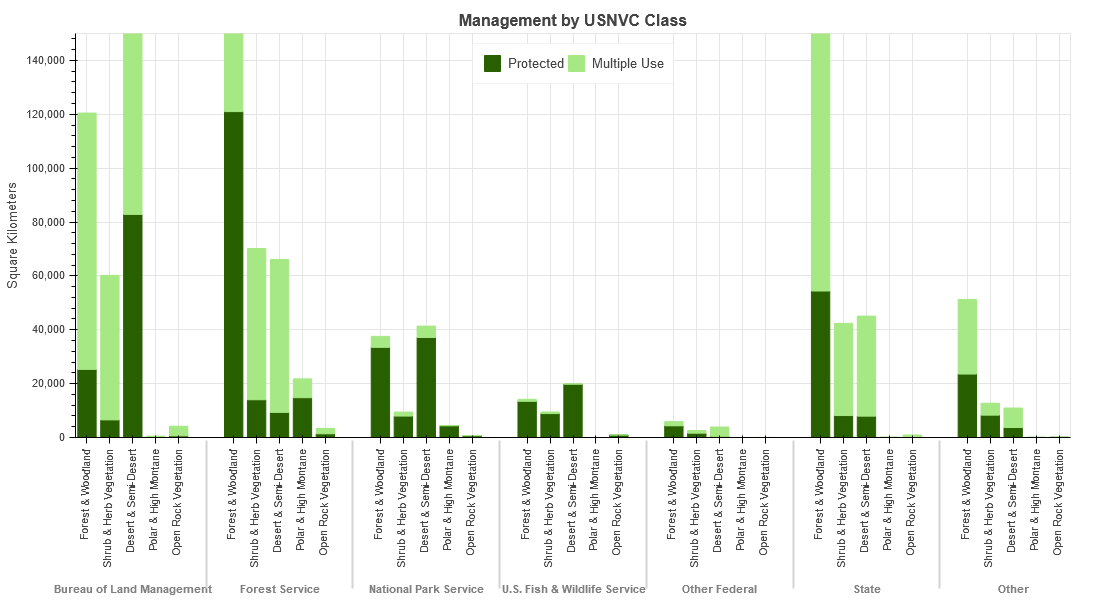

In [13]:
# The following will render the HTML file in the notebook using a local file source
from IPython.core.display import display, HTML, Image
#display(HTML(filename=workDir + "/ManagementSummary.html"))
# To display this on GitHub, render a screenshot image
repoDir = "C:/Data/USGS Analyses/NVC-Analyses"
display(Image(filename=repoDir + '/ManagementSummaryImage.png', embed=True))

<html lang="en">
    <head>
        <meta charset="utf-8">
        <title>Bokeh Plot</title>
        
<link rel="stylesheet" href="https://cdn.pydata.org/bokeh/release/bokeh-0.12.16.min.css" type="text/css" />
        
<script type="text/javascript" src="https://cdn.pydata.org/bokeh/release/bokeh-0.12.16.min.js"></script>
<script type="text/javascript">
    Bokeh.set_log_level("info");
</script>
    </head>
    <body>
        
        <div class="bk-root">
            <div class="bk-plotdiv" id="7fac4a96-385c-41a8-b369-a59cb02d005d"></div>
        </div>
        
        <script type="application/json" id="d98a57b7-ca87-454f-8313-959ee1e389da">
          {"40651963-2452-42aa-a7f1-ffb9ec5a1bfa":{"roots":{"references":[{"attributes":{"overlay":{"id":"a7f3c7d3-2f59-4c05-8b2f-ef298600f35a","type":"BoxAnnotation"}},"id":"22f22777-0afb-40c6-a597-261c2a6562bb","type":"BoxZoomTool"},{"attributes":{},"id":"986bb194-ed00-4d59-9774-96ad97498bca","type":"ResetTool"},{"attributes":{},"id":"60f9b99d-3296-4cb6-a742-93ec7c07ab1a","type":"HelpTool"},{"attributes":{"label":{"value":"Multiple Use"},"renderers":[{"id":"44031268-1c73-40a6-bc6a-06e5463638dd","type":"GlyphRenderer"}]},"id":"f584825b-42ff-4789-a940-0ee4cdb7ad19","type":"LegendItem"},{"attributes":{"callback":null,"data":{"CatCls":[["Bureau of Land Management","Forest &amp; Woodland"],["Bureau of Land Management","Shrub &amp; Herb Vegetation"],["Bureau of Land Management","Desert &amp; Semi-Desert"],["Bureau of Land Management","Polar &amp; High Montane"],["Bureau of Land Management","Open Rock Vegetation"],["Forest Service","Forest &amp; Woodland"],["Forest Service","Shrub &amp; Herb Vegetation"],["Forest Service","Desert &amp; Semi-Desert"],["Forest Service","Polar &amp; High Montane"],["Forest Service","Open Rock Vegetation"],["National Park Service","Forest &amp; Woodland"],["National Park Service","Shrub &amp; Herb Vegetation"],["National Park Service","Desert &amp; Semi-Desert"],["National Park Service","Polar &amp; High Montane"],["National Park Service","Open Rock Vegetation"],["U.S. Fish &amp; Wildlife Service","Forest &amp; Woodland"],["U.S. Fish &amp; Wildlife Service","Shrub &amp; Herb Vegetation"],["U.S. Fish &amp; Wildlife Service","Desert &amp; Semi-Desert"],["U.S. Fish &amp; Wildlife Service","Polar &amp; High Montane"],["U.S. Fish &amp; Wildlife Service","Open Rock Vegetation"],["Other Federal","Forest &amp; Woodland"],["Other Federal","Shrub &amp; Herb Vegetation"],["Other Federal","Desert &amp; Semi-Desert"],["Other Federal","Polar &amp; High Montane"],["Other Federal","Open Rock Vegetation"],["State","Forest &amp; Woodland"],["State","Shrub &amp; Herb Vegetation"],["State","Desert &amp; Semi-Desert"],["State","Polar &amp; High Montane"],["State","Open Rock Vegetation"],["Other","Forest &amp; Woodland"],["Other","Shrub &amp; Herb Vegetation"],["Other","Desert &amp; Semi-Desert"],["Other","Polar &amp; High Montane"],["Other","Open Rock Vegetation"]],"Multiple Use":{"__ndarray__":"p3nHKS4890CC4seYDTLqQJI6AQ1gGBpB7zhFR3Idb0Dx0k1iUMerQABvgcTkHSdBQ61p3sFo+0BwXwfOZbz7QG6jAbwVRctAKqkT0IRPr0A2PL1SVt2/QJHtfD91/6ZASuoENKGAwECdgCbChqcBQHlYqDXN+zxAc2iR7Xxxh0C8dJMYBHeCQOF6FK5HSVZAkst/SL99TT/x0k1iEFipP2YZ4ljXN5dAMeauJWRjjkCLbOf7Se2qQNzXgXNGlKY/4C2QoPjhNECoxks3Wpj5QNy1hHxmuOBA+8vuyUMi4kAFNBE2PJVAQBLyQc/mColABaOSOh035kCOdXEbPbO9QKNwPQrHV7xA8rBQa5p3MUA9m1Wfq60kQA==","dtype":"float64","shape":[35]},"Protected":{"__ndarray__":"9NvXgXez2ECKjuTyD425QAbwFkgvOfRAjNtoAG8BcEBDi2zn+1ODQDGZKhi2ig1BibDh6R1g20Dc14FzzjHSQBiV1Ang3txAsAPnjGiPpUAVjErqxlfwQEMc6+L2GM9AS1mGOMYh8kC0N/jCNCjBQEI+6NksbJVA845TdBQ8ykBqTfOOa1vBQPRsVn3CV9NASS7/If32AkDXEvJBT6ONQLdif9k9EXhAQBNhw9MjW0ACvAUSFN8gQAAAAAAAAAAArdhfdk8etj8B3gIJxyPxQB3J5T9MnstAxbEubhPewkA0gLdAgkpDQPkP6bevp19A2PD0SqnW40ADCYofA+/EQAArhxb5765AhetRuB79QUAgFmpN80ZXQA==","dtype":"float64","shape":[35]}},"selected":{"id":"d9e39b58-ac22-45ef-bdce-c0e53f94f4e7","type":"Selection"},"selection_policy":{"id":"fdf062eb-e3d1-4f3e-af81-c49fb01501f0","type":"UnionRenderers"}},"id":"d8d94fce-385d-4450-8b37-0ea6cc3b2e2b","type":"ColumnDataSource"},{"attributes":{},"id":"d9e39b58-ac22-45ef-bdce-c0e53f94f4e7","type":"Selection"},{"attributes":{"fields":["Protected","Multiple Use"]},"id":"4860e60b-f1d8-4e14-ba1a-e56c22a1a380","type":"Stack"},{"attributes":{},"id":"22a553dc-8ffa-465b-bacf-f148736e706b","type":"Selection"},{"attributes":{"fields":["Protected"]},"id":"25515667-2032-421c-a16d-23bdd5b2789a","type":"Stack"},{"attributes":{"source":{"id":"d8d94fce-385d-4450-8b37-0ea6cc3b2e2b","type":"ColumnDataSource"}},"id":"186e7bee-dd1b-4c82-97d5-d8835c64b4e0","type":"CDSView"},{"attributes":{"bottom":{"expr":{"id":"a5a00582-6256-45c2-9aa8-42e26d3dc972","type":"Stack"}},"fill_alpha":{"value":0.1},"fill_color":{"value":"#1f77b4"},"line_alpha":{"value":0.1},"line_color":{"value":"#1f77b4"},"top":{"expr":{"id":"4860e60b-f1d8-4e14-ba1a-e56c22a1a380","type":"Stack"}},"width":{"value":0.8},"x":{"field":"CatCls"}},"id":"492e08c2-ffd1-473c-96de-05682eec3390","type":"VBar"},{"attributes":{"callback":null,"factors":[["Bureau of Land Management","Forest &amp; Woodland"],["Bureau of Land Management","Shrub &amp; Herb Vegetation"],["Bureau of Land Management","Desert &amp; Semi-Desert"],["Bureau of Land Management","Polar &amp; High Montane"],["Bureau of Land Management","Open Rock Vegetation"],["Forest Service","Forest &amp; Woodland"],["Forest Service","Shrub &amp; Herb Vegetation"],["Forest Service","Desert &amp; Semi-Desert"],["Forest Service","Polar &amp; High Montane"],["Forest Service","Open Rock Vegetation"],["National Park Service","Forest &amp; Woodland"],["National Park Service","Shrub &amp; Herb Vegetation"],["National Park Service","Desert &amp; Semi-Desert"],["National Park Service","Polar &amp; High Montane"],["National Park Service","Open Rock Vegetation"],["U.S. Fish &amp; Wildlife Service","Forest &amp; Woodland"],["U.S. Fish &amp; Wildlife Service","Shrub &amp; Herb Vegetation"],["U.S. Fish &amp; Wildlife Service","Desert &amp; Semi-Desert"],["U.S. Fish &amp; Wildlife Service","Polar &amp; High Montane"],["U.S. Fish &amp; Wildlife Service","Open Rock Vegetation"],["Other Federal","Forest &amp; Woodland"],["Other Federal","Shrub &amp; Herb Vegetation"],["Other Federal","Desert &amp; Semi-Desert"],["Other Federal","Polar &amp; High Montane"],["Other Federal","Open Rock Vegetation"],["State","Forest &amp; Woodland"],["State","Shrub &amp; Herb Vegetation"],["State","Desert &amp; Semi-Desert"],["State","Polar &amp; High Montane"],["State","Open Rock Vegetation"],["Other","Forest &amp; Woodland"],["Other","Shrub &amp; Herb Vegetation"],["Other","Desert &amp; Semi-Desert"],["Other","Polar &amp; High Montane"],["Other","Open Rock Vegetation"]]},"id":"3a683604-4f05-4a99-85f7-f711325bb357","type":"FactorRange"},{"attributes":{"items":[{"id":"956518fd-96f4-46ad-b70f-5afb25ad77eb","type":"LegendItem"},{"id":"f584825b-42ff-4789-a940-0ee4cdb7ad19","type":"LegendItem"}],"location":"top_center","orientation":"horizontal","plot":{"id":"7ced2dc0-f397-4ab5-b15b-a495197e8791","subtype":"Figure","type":"Plot"}},"id":"b953daf7-48c6-487d-8e24-292f8606fffb","type":"Legend"},{"attributes":{},"id":"4f8aed70-d039-4077-8f31-a9f6c3b55632","type":"UnionRenderers"},{"attributes":{"bottom":{"expr":{"id":"58504ae5-6f9c-4efd-b534-a5432e82523e","type":"Stack"}},"fill_alpha":{"value":0.1},"fill_color":{"value":"#1f77b4"},"line_alpha":{"value":0.1},"line_color":{"value":"#1f77b4"},"top":{"expr":{"id":"25515667-2032-421c-a16d-23bdd5b2789a","type":"Stack"}},"width":{"value":0.8},"x":{"field":"CatCls"}},"id":"54c5a42e-2079-4113-a74b-ac9f3f3e18aa","type":"VBar"},{"attributes":{"below":[{"id":"4daa859b-7365-4a56-a1e4-e79c501723f0","type":"CategoricalAxis"}],"left":[{"id":"336963b9-27b3-4dcf-8697-8ea09c7e4c53","type":"LinearAxis"}],"plot_width":1000,"renderers":[{"id":"4daa859b-7365-4a56-a1e4-e79c501723f0","type":"CategoricalAxis"},{"id":"3e78ac59-aa61-4510-83c7-8b757cc582ff","type":"Grid"},{"id":"336963b9-27b3-4dcf-8697-8ea09c7e4c53","type":"LinearAxis"},{"id":"a7751899-d570-4f42-b530-f8085e482401","type":"Grid"},{"id":"a7f3c7d3-2f59-4c05-8b2f-ef298600f35a","type":"BoxAnnotation"},{"id":"b953daf7-48c6-487d-8e24-292f8606fffb","type":"Legend"},{"id":"d43e5a9b-667e-400e-a107-5df4f2ebb102","type":"GlyphRenderer"},{"id":"44031268-1c73-40a6-bc6a-06e5463638dd","type":"GlyphRenderer"}],"title":{"id":"2906c55c-5df1-4adf-82e6-b917d3fa4c0b","type":"Title"},"toolbar":{"id":"1ba5bfb4-0a5b-42de-ad30-755b0c1f7839","type":"Toolbar"},"x_range":{"id":"3a683604-4f05-4a99-85f7-f711325bb357","type":"FactorRange"},"x_scale":{"id":"a3581ca2-7e6b-4395-bfe4-359772157983","type":"CategoricalScale"},"y_range":{"id":"4e7a99f0-a31d-4c98-9387-334b8d7ada4f","type":"DataRange1d"},"y_scale":{"id":"bb176458-9d6a-4125-a03c-d4bfad4fbe51","type":"LinearScale"}},"id":"7ced2dc0-f397-4ab5-b15b-a495197e8791","subtype":"Figure","type":"Plot"},{"attributes":{"bottom":{"expr":{"id":"a5a00582-6256-45c2-9aa8-42e26d3dc972","type":"Stack"}},"fill_color":{"value":"#a6e883"},"line_color":{"value":"#a6e883"},"top":{"expr":{"id":"4860e60b-f1d8-4e14-ba1a-e56c22a1a380","type":"Stack"}},"width":{"value":0.8},"x":{"field":"CatCls"}},"id":"b96b4a39-bdb9-4277-bfa2-916ad277059c","type":"VBar"},{"attributes":{"align":"center","plot":null,"text":"Management by USNVC Class","text_font_size":{"value":"18pt"}},"id":"2906c55c-5df1-4adf-82e6-b917d3fa4c0b","type":"Title"},{"attributes":{"callback":null,"end":150000,"start":0},"id":"4e7a99f0-a31d-4c98-9387-334b8d7ada4f","type":"DataRange1d"},{"attributes":{"callback":null,"data":{"CatCls":[["Bureau of Land Management","Forest &amp; Woodland"],["Bureau of Land Management","Shrub &amp; Herb Vegetation"],["Bureau of Land Management","Desert &amp; Semi-Desert"],["Bureau of Land Management","Polar &amp; High Montane"],["Bureau of Land Management","Open Rock Vegetation"],["Forest Service","Forest &amp; Woodland"],["Forest Service","Shrub &amp; Herb Vegetation"],["Forest Service","Desert &amp; Semi-Desert"],["Forest Service","Polar &amp; High Montane"],["Forest Service","Open Rock Vegetation"],["National Park Service","Forest &amp; Woodland"],["National Park Service","Shrub &amp; Herb Vegetation"],["National Park Service","Desert &amp; Semi-Desert"],["National Park Service","Polar &amp; High Montane"],["National Park Service","Open Rock Vegetation"],["U.S. Fish &amp; Wildlife Service","Forest &amp; Woodland"],["U.S. Fish &amp; Wildlife Service","Shrub &amp; Herb Vegetation"],["U.S. Fish &amp; Wildlife Service","Desert &amp; Semi-Desert"],["U.S. Fish &amp; Wildlife Service","Polar &amp; High Montane"],["U.S. Fish &amp; Wildlife Service","Open Rock Vegetation"],["Other Federal","Forest &amp; Woodland"],["Other Federal","Shrub &amp; Herb Vegetation"],["Other Federal","Desert &amp; Semi-Desert"],["Other Federal","Polar &amp; High Montane"],["Other Federal","Open Rock Vegetation"],["State","Forest &amp; Woodland"],["State","Shrub &amp; Herb Vegetation"],["State","Desert &amp; Semi-Desert"],["State","Polar &amp; High Montane"],["State","Open Rock Vegetation"],["Other","Forest &amp; Woodland"],["Other","Shrub &amp; Herb Vegetation"],["Other","Desert &amp; Semi-Desert"],["Other","Polar &amp; High Montane"],["Other","Open Rock Vegetation"]],"Multiple Use":{"__ndarray__":"p3nHKS4890CC4seYDTLqQJI6AQ1gGBpB7zhFR3Idb0Dx0k1iUMerQABvgcTkHSdBQ61p3sFo+0BwXwfOZbz7QG6jAbwVRctAKqkT0IRPr0A2PL1SVt2/QJHtfD91/6ZASuoENKGAwECdgCbChqcBQHlYqDXN+zxAc2iR7Xxxh0C8dJMYBHeCQOF6FK5HSVZAkst/SL99TT/x0k1iEFipP2YZ4ljXN5dAMeauJWRjjkCLbOf7Se2qQNzXgXNGlKY/4C2QoPjhNECoxks3Wpj5QNy1hHxmuOBA+8vuyUMi4kAFNBE2PJVAQBLyQc/mColABaOSOh035kCOdXEbPbO9QKNwPQrHV7xA8rBQa5p3MUA9m1Wfq60kQA==","dtype":"float64","shape":[35]},"Protected":{"__ndarray__":"9NvXgXez2ECKjuTyD425QAbwFkgvOfRAjNtoAG8BcEBDi2zn+1ODQDGZKhi2ig1BibDh6R1g20Dc14FzzjHSQBiV1Ang3txAsAPnjGiPpUAVjErqxlfwQEMc6+L2GM9AS1mGOMYh8kC0N/jCNCjBQEI+6NksbJVA845TdBQ8ykBqTfOOa1vBQPRsVn3CV9NASS7/If32AkDXEvJBT6ONQLdif9k9EXhAQBNhw9MjW0ACvAUSFN8gQAAAAAAAAAAArdhfdk8etj8B3gIJxyPxQB3J5T9MnstAxbEubhPewkA0gLdAgkpDQPkP6bevp19A2PD0SqnW40ADCYofA+/EQAArhxb5765AhetRuB79QUAgFmpN80ZXQA==","dtype":"float64","shape":[35]}},"selected":{"id":"22a553dc-8ffa-465b-bacf-f148736e706b","type":"Selection"},"selection_policy":{"id":"4f8aed70-d039-4077-8f31-a9f6c3b55632","type":"UnionRenderers"}},"id":"2781df5a-e2b3-4a4f-9ff9-ab8f4aa8f739","type":"ColumnDataSource"},{"attributes":{"active_drag":"auto","active_inspect":"auto","active_scroll":"auto","active_tap":"auto","tools":[{"id":"a392dc12-671d-4480-9f22-13082ec4d9f5","type":"PanTool"},{"id":"486e5cc6-4312-408b-8aba-58f9e13ba1c3","type":"WheelZoomTool"},{"id":"22f22777-0afb-40c6-a597-261c2a6562bb","type":"BoxZoomTool"},{"id":"cdf975d1-99b3-41ac-bcc3-1cbb67409949","type":"SaveTool"},{"id":"986bb194-ed00-4d59-9774-96ad97498bca","type":"ResetTool"},{"id":"60f9b99d-3296-4cb6-a742-93ec7c07ab1a","type":"HelpTool"}]},"id":"1ba5bfb4-0a5b-42de-ad30-755b0c1f7839","type":"Toolbar"},{"attributes":{"fields":["Protected"]},"id":"a5a00582-6256-45c2-9aa8-42e26d3dc972","type":"Stack"},{"attributes":{"data_source":{"id":"2781df5a-e2b3-4a4f-9ff9-ab8f4aa8f739","type":"ColumnDataSource"},"glyph":{"id":"b96b4a39-bdb9-4277-bfa2-916ad277059c","type":"VBar"},"hover_glyph":null,"muted_glyph":null,"nonselection_glyph":{"id":"492e08c2-ffd1-473c-96de-05682eec3390","type":"VBar"},"selection_glyph":null,"view":{"id":"3d08e7d6-5d06-4b2d-8fdc-e7c68ac15b52","type":"CDSView"}},"id":"44031268-1c73-40a6-bc6a-06e5463638dd","type":"GlyphRenderer"},{"attributes":{},"id":"bb176458-9d6a-4125-a03c-d4bfad4fbe51","type":"LinearScale"},{"attributes":{"source":{"id":"2781df5a-e2b3-4a4f-9ff9-ab8f4aa8f739","type":"ColumnDataSource"}},"id":"3d08e7d6-5d06-4b2d-8fdc-e7c68ac15b52","type":"CDSView"},{"attributes":{},"id":"a3581ca2-7e6b-4395-bfe4-359772157983","type":"CategoricalScale"},{"attributes":{"bottom":{"expr":{"id":"58504ae5-6f9c-4efd-b534-a5432e82523e","type":"Stack"}},"fill_color":{"value":"#286000"},"line_color":{"value":"#286000"},"top":{"expr":{"id":"25515667-2032-421c-a16d-23bdd5b2789a","type":"Stack"}},"width":{"value":0.8},"x":{"field":"CatCls"}},"id":"9cb1e217-b3b0-47f1-878c-ab3364c42928","type":"VBar"},{"attributes":{"axis_label":"Square Kilometers","axis_label_text_font_style":"normal","formatter":{"id":"8e11a7ac-0e96-4f5b-a89e-a8043c4ba28f","type":"NumeralTickFormatter"},"plot":{"id":"7ced2dc0-f397-4ab5-b15b-a495197e8791","subtype":"Figure","type":"Plot"},"ticker":{"id":"9a118d1b-8d09-46a2-a627-4a939ec80334","type":"BasicTicker"}},"id":"336963b9-27b3-4dcf-8697-8ea09c7e4c53","type":"LinearAxis"},{"attributes":{"axis_label_text_font_style":"normal","formatter":{"id":"60904d32-badb-44e2-95b6-47687f653771","type":"CategoricalTickFormatter"},"major_label_orientation":1.55,"plot":{"id":"7ced2dc0-f397-4ab5-b15b-a495197e8791","subtype":"Figure","type":"Plot"},"ticker":{"id":"af87f2c8-74e6-44bc-a29d-641e0b874595","type":"CategoricalTicker"}},"id":"4daa859b-7365-4a56-a1e4-e79c501723f0","type":"CategoricalAxis"},{"attributes":{},"id":"af87f2c8-74e6-44bc-a29d-641e0b874595","type":"CategoricalTicker"},{"attributes":{"plot":{"id":"7ced2dc0-f397-4ab5-b15b-a495197e8791","subtype":"Figure","type":"Plot"},"ticker":{"id":"af87f2c8-74e6-44bc-a29d-641e0b874595","type":"CategoricalTicker"}},"id":"3e78ac59-aa61-4510-83c7-8b757cc582ff","type":"Grid"},{"attributes":{},"id":"9a118d1b-8d09-46a2-a627-4a939ec80334","type":"BasicTicker"},{"attributes":{"dimension":1,"plot":{"id":"7ced2dc0-f397-4ab5-b15b-a495197e8791","subtype":"Figure","type":"Plot"},"ticker":{"id":"9a118d1b-8d09-46a2-a627-4a939ec80334","type":"BasicTicker"}},"id":"a7751899-d570-4f42-b530-f8085e482401","type":"Grid"},{"attributes":{"bottom_units":"screen","fill_alpha":{"value":0.5},"fill_color":{"value":"lightgrey"},"left_units":"screen","level":"overlay","line_alpha":{"value":1.0},"line_color":{"value":"black"},"line_dash":[4,4],"line_width":{"value":2},"plot":null,"render_mode":"css","right_units":"screen","top_units":"screen"},"id":"a7f3c7d3-2f59-4c05-8b2f-ef298600f35a","type":"BoxAnnotation"},{"attributes":{"data_source":{"id":"d8d94fce-385d-4450-8b37-0ea6cc3b2e2b","type":"ColumnDataSource"},"glyph":{"id":"9cb1e217-b3b0-47f1-878c-ab3364c42928","type":"VBar"},"hover_glyph":null,"muted_glyph":null,"nonselection_glyph":{"id":"54c5a42e-2079-4113-a74b-ac9f3f3e18aa","type":"VBar"},"selection_glyph":null,"view":{"id":"186e7bee-dd1b-4c82-97d5-d8835c64b4e0","type":"CDSView"}},"id":"d43e5a9b-667e-400e-a107-5df4f2ebb102","type":"GlyphRenderer"},{"attributes":{"fields":[]},"id":"58504ae5-6f9c-4efd-b534-a5432e82523e","type":"Stack"},{"attributes":{"label":{"value":"Protected"},"renderers":[{"id":"d43e5a9b-667e-400e-a107-5df4f2ebb102","type":"GlyphRenderer"}]},"id":"956518fd-96f4-46ad-b70f-5afb25ad77eb","type":"LegendItem"},{"attributes":{},"id":"8e11a7ac-0e96-4f5b-a89e-a8043c4ba28f","type":"NumeralTickFormatter"},{"attributes":{},"id":"a392dc12-671d-4480-9f22-13082ec4d9f5","type":"PanTool"},{"attributes":{},"id":"60904d32-badb-44e2-95b6-47687f653771","type":"CategoricalTickFormatter"},{"attributes":{},"id":"cdf975d1-99b3-41ac-bcc3-1cbb67409949","type":"SaveTool"},{"attributes":{},"id":"fdf062eb-e3d1-4f3e-af81-c49fb01501f0","type":"UnionRenderers"},{"attributes":{},"id":"486e5cc6-4312-408b-8aba-58f9e13ba1c3","type":"WheelZoomTool"}],"root_ids":["7ced2dc0-f397-4ab5-b15b-a495197e8791"]},"title":"Bokeh Application","version":"0.12.16"}}
        </script>
        <script type="text/javascript">
          (function() {
            var fn = function() {
              Bokeh.safely(function() {
                (function(root) {
                  function embed_document(root) {
                    
                  var docs_json = document.getElementById('d98a57b7-ca87-454f-8313-959ee1e389da').textContent;
                  var render_items = [{"docid":"40651963-2452-42aa-a7f1-ffb9ec5a1bfa","elementid":"7fac4a96-385c-41a8-b369-a59cb02d005d","modelid":"7ced2dc0-f397-4ab5-b15b-a495197e8791"}];
                  root.Bokeh.embed.embed_items(docs_json, render_items);
                
                  }
                  if (root.Bokeh !== undefined) {
                    embed_document(root);
                  } else {
                    var attempts = 0;
                    var timer = setInterval(function(root) {
                      if (root.Bokeh !== undefined) {
                        embed_document(root);
                        clearInterval(timer);
                      }
                      attempts++;
                      if (attempts > 100) {
                        console.log("Bokeh: ERROR: Unable to run BokehJS code because BokehJS library is missing")
                        clearInterval(timer);
                      }
                    }, 10, root)
                  }
                })(window);
              });
            };
            if (document.readyState != "loading") fn();
            else document.addEventListener("DOMContentLoaded", fn);
          })();
        </script>
    </body>
</html>